# 机器学习工程师纳米学位
## 监督学习
## 项目 2: 搭建一个学生干预系统

欢迎来到机器学习工程师纳米学位的第二个项目！在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以**'练习'**开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以**'TODO'**标出。请仔细阅读所有的提示！

除了实现代码外，你还**必须**回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

### 问题 1 - 分类 vs. 回归
*在这个项目中你的任务是找出那些如果不给予帮助，最重可能无法毕业的学生。你觉得这个问题是哪种类型的监督学习问题，是分类问题还是回归问题？为什么？*

**答案: **分类问题。因为需要把学生分为2类，一类是普通，一类是“如果不给予帮助，最终可能无法毕业的学生”这个类别。

## 分析数据
运行下面区域的代码以载入学生数据集，以及一些此项目所需的Python库。注意数据集的最后一列`'passed'`是我们的预测的目标（表示学生是毕业了还是没有毕业），其他的列是每个学生的属性。

In [2]:
# 载入所需要的库
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# 载入学生数据集
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### 练习: 分析数据
我们首先通过调查数据，以确定有多少学生的信息，并了解这些学生的毕业率。在下面的代码单元中，你需要完成如下的运算：
- 学生的总数， `n_students`。
- 每个学生的特征总数， `n_features`。
- 毕业的学生的数量， `n_passed`。
- 未毕业的学生的数量， `n_failed`。
- 班级的毕业率， `grad_rate`， 用百分数表示(%)。


In [3]:
# TODO： 计算学生的数量
n_students = len(student_data)

# TODO： 计算特征数量
n_features = len(student_data.columns)-1

# TODO： 计算通过的学生数
n_passed = len(student_data[student_data.passed=='yes'])

# TODO： 计算未通过的学生数
n_failed = len(student_data[student_data.passed=='no'])

# TODO： 计算通过率
grad_rate = n_passed/float(n_students)*100

# 输出结果
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## 数据准备
在这个部分中，我们将要为建模、训练和测试准备数据
### 识别特征和目标列
你获取的数据中通常都会包含一些非数字的特征，这会导致一些问题，因为大多数的机器学习算法都会期望输入数字特征进行计算。

运行下面的代码单元将学生数据分成特征和目标列看一看他们中是否有非数字特征。

In [5]:
# 提取特征列
feature_cols = list(student_data.columns[:-1])

# 提取目标列 ‘passed’
target_col = student_data.columns[-1] 

# 显示列的列表
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# 将数据分割成特征数据和目标数据（即X_all 和 y_all）
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# 通过打印前5行显示特征信息
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### 预处理特征列

正如你所见，我们这里有几个非数值的列需要做一定的转换！它们中很多是简单的`yes`/`no`，比如`internet`。这些可以合理地转化为`1`/`0`（二元值，binary）值。

其他的列，如`Mjob`和`Fjob`，有两个以上的值，被称为_分类变量（categorical variables）_。处理这样的列的推荐方法是创建和可能值一样多的列（如：`Fjob_teacher`，`Fjob_other`，`Fjob_services`等），然后将其中一个的值设为`1`另外的设为`0`。

这些创建的列有时候叫做 _虚拟变量（dummy variables）_，我们将用[`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies)函数来完成这个转换。运行下面代码单元的代码来完成这里讨论的预处理步骤。

In [27]:
def preprocess_features(X):
    ''' 预处理学生数据，将非数字的二元特征转化成二元值（0或1），将分类的变量转换成虚拟变量
    '''
    
    # 初始化一个用于输出的DataFrame
    output = pd.DataFrame(index = X.index)
   
    # 查看数据的每一个特征列
    for col, col_data in X.iteritems():
        
        # 如果数据是非数字类型，将所有的yes/no替换成1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # 如果上面代码后，还不是数字，则数据类型是类别的（categorical），将它转换成虚拟变量
        if col_data.dtype == object:
            # 例子: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # 收集转换后的列
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### 实现: 将数据分成训练集和测试集
现在我们已经将所有的 _分类的（categorical）_ 特征转换成数值了。下一步我们将把数据（包括特征和对应的标签数据）分割成训练集和测试集。在下面的代码单元中，你需要完成下列功能：
- 随机混洗（shuffle）切分数据(`X_all`, `y_all`) 为训练子集和测试子集。
  - 使用300个数据点作为训练集（约75%），使用95个数据点作为测试集（约25%）。
  - 如果可能的话，为你使用的函数设置一个`random_state`。
  - 将结果存储在`X_train`, `X_test`, `y_train`和 `y_test`中。

## 训练和评价模型
在这个部分，你将选择3个适合这个问题并且在`scikit-learn`中已有的监督学习的模型。首先你需要说明你选择这三个模型的原因，包括这些数据集有哪些特点，每个模型的优点和缺点各是什么。然后，你需要将这些模型用不同大小的训练集（100个数据点，200个数据点，300个数据点）进行训练，并用F<sub>1</sub>的值来衡量。你需要制作三个表，每个表要显示训练集大小，训练时间，预测时间，训练集上的F<sub>1</sub>值和测试集上的F<sub>1</sub>值（每个模型一个表）。

**这是目前** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **里有的监督学习模型，你可以从中选择:**
- Gaussian Naive Bayes (GaussianNB) 朴素贝叶斯
- Decision Trees 决策树
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM) 向量模型机
- Logistic Regression 逻辑回归

In [35]:
# TODO：在这里导入你可能需要使用的另外的功能
student_data_all = preprocess_features(student_data)

# TODO：设置训练集的数量
num_train = 300

# TODO：设置测试集的数量
num_test = student_data_all.shape[0] - num_train

# TODO：把数据集混洗和分割成上面定义的训练集和测试集

student_data_all_values = student_data_all.values
# print X_all_values[:10,4]
np.random.shuffle(student_data_all_values)
# print X_all_values[:10,4]

X_train = student_data_all_values[:-num_test,:-1]
X_test = student_data_all_values[-num_test:,:-1]
y_train = student_data_all_values[:-num_test,-1]
y_test = student_data_all_values[-num_test:,-1]
# print y_test

# 显示分割的结果
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])



Training set has 300 samples.
Testing set has 95 samples.


### 问题 2 - 应用模型
*列出三个适合这个问题的监督学习算法模型。每一个你选择的模型：*

- 描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）
- 这个模型的优势是什么？他什么情况下表现最好？
- 这个模型的缺点是什么？什么条件下它表现很差？
- 根据我们当前数据集的特点，为什么这个模型适合这个问题。

**回答: **Decision Trees, SVM, Ensemble Methods.<br />
<br />
决策树一个应用场景是商业和工业界的数据挖掘，参考自论文“Apté C, Weiss S. Data mining with decision trees and decision rules[J]. Future generation computer systems, 1997, 13(2): 197-210.”<br />
决策树的优势：1）易于理解和解释原因；2）在数据较少的情况下，依旧有效；3）可以很好的支持离散化的输入特征；4）能够在相对较短时间训练很大量的数据；<br />
决策树的劣势：1）容易过拟合；2）计算可能变得非常复杂；<br />
决策树为什么合适？ 一是当前数据集小，二是当前数据集离散化的特征较多；
<br />
SVM支持向量机，一个应用场景是手写字体的识别，参考自论文“Adankon M M, Cheriet M. Model selection for the LS-SVM. Application to handwriting recognition[J]. Pattern Recognition, 2009, 42(12): 3264-3270.”<br />
SVM 的优势：1）在复杂的邻域、小数据集上表现良好；2）有坚实的理论基础，目标函数符合凸优化；3）预测时，只取决于支持向量，某种程度上避免了“维度灾难”；<br />
SVM 的劣势：1）在海量数据集中，表现不好，因为训练时间过长；2）噪声敏感，在有噪声的数据集中表现不好；3）解决多分类问题存在困难；<br />
SVM 为什么适合？一是当前数据集小，且复杂（feature 很多），二是当前问题是二分类问题，适合 SVM；<br />
<br />
Ensemble Methods在生物领域有不少应用。<br />
比如药用分子的Quantitative Structure-Activity Relationship (QSAR)建模，参考论文“Svetnik V, Liaw A, Tong C, et al. Application of Breiman’s random forest to modeling structure-activity relationships of pharmaceutical molecules[C]//International Workshop on Multiple Classifier Systems. Springer Berlin Heidelberg, 2004: 334-343.”<br />
再比如基因数据的分析，参考论文“Díaz-Uriarte R, De Andres S A. Gene selection and classification of microarray data using random forest[J]. BMC bioinformatics, 2006, 7(1): 1.”<br />
Ensemble Methods 的优势：1）擅长处理实际问题；2）灵活，可以组合使用几种机器学习算法，或者一种算法的不同参数组合；3）不容易过拟合；<br />
Ensemble Methods 的劣势：1）训练时间过长；2)计算复杂，预测运算的时间长；<br />
Ensemble Methods 为什么适合？一是Ensemble Methods适合实际问题分析，二是数据集小，该方法可以避免过拟合；

### 准备
运行下面的代码单元以初始化三个帮助函数，这三个函数将能够帮你训练和测试你上面所选择的三个监督学习算法。这些函数是：
- `train_classifier` - 输入一个分类器和训练集，用数据来训练这个分类器。
- `predict_labels` - 输入一个训练好的分类器、特征以及一个目标标签，这个函数将帮你做预测并给出F<sub>1</sub>的值.
- `train_predict` - 输入一个分类器以及训练集和测试集，它可以运行`train_clasifier`和`predict_labels`.
 - 这个函数将分别输出训练集的F<sub>1</sub>值和测试集的F<sub>1</sub>值

In [36]:
def train_classifier(clf, X_train, y_train):
    ''' 用训练集训练分类器 '''
    
    # 开始计时，训练分类器，然后停止计时
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' 用训练好的分类器做预测并输出F1值'''
    
    # 开始计时，作出预测，然后停止计时
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # 输出并返回结果
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target, y_pred, pos_label=0)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' 用一个分类器训练和预测，并输出F1值 '''
    
    # 输出分类器名称和训练集大小
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # 训练一个分类器
    train_classifier(clf, X_train, y_train)
    
    # 输出训练和测试的预测结果
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### 练习: 模型评价指标
借助于上面定义的函数，你现在需要导入三个你选择的监督学习模型，然后为每一个模型运行`train_predict`函数。请记住，对于每一个模型你需要在不同大小的训练集（100，200和300）上进行训练和测试。所以，你在下面应该会有9个不同的输出（每个模型都有训练集大小不同的三个输出）。在接下来的代码单元中，你将需要实现以下功能：
- 引入三个你在上面讨论过的监督式学习算法模型。
- 初始化三个模型并将它们存储在`clf_A`， `clf_B` 和 `clf_C`中。
 - 如果可能对每一个模型都设置一个`random_state`。
 - **注意:** 这里先使用每一个模型的默认参数，在接下来的部分中你将需要对某一个模型的参数进行调整。
- 创建不同大小的训练集用来训练每一个模型。
 - *不要再混洗和再分割数据！新的训练集要取自`X_train`和`y_train`.*
- 对于每一个模型要用不同大小的训练集来训练它，然后在测试集上做测试（总共需要9次训练测试）   
**注意:** 在下面的代码单元后面我们提供了三个表用来存储你的结果。

In [37]:
# TODO：从sklearn中引入三个监督学习模型
# from sklearn import model_A
from sklearn.tree import DecisionTreeClassifier
# from sklearn import model_B
from sklearn import svm
# from skearln import model_C
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# TODO：初始化三个模型
# clf_A = GaussianNB()
clf_A = DecisionTreeClassifier()
clf_B = svm.SVC()
clf_C = AdaBoostClassifier()

# TODO：设置训练集大小


# TODO：对每一个分类器和每一个训练集大小运行'train_predict' 
# train_predict(clf, X_train, y_train, X_test, y_test)

for clf in [clf_A, clf_B, clf_C]:
    print "\n---[clg.type]:",clf.__class__.__name__
    for train_size in [100, 200, 300]:
        print ""
        train_predict(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)


---[clg.type]: DecisionTreeClassifier

Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0015 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0001 seconds.
F1 score for test set: 0.4507.

Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0013 seconds
Made predictions in 0.0003 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0002 seconds.
F1 score for test set: 0.4865.

Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0017 seconds
Made predictions in 0.0003 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0002 seconds.
F1 score for test set: 0.4706.

---[clg.type]: SVC

Training a SVC using a training set size of 100. . .
Trained model in 0.0011 seconds
Made predictions in 0.0006 seconds.
F1 score for training set: 0.2703.
Made predictions in 0.0006 seconds.
F1 score for test s

### 结果表格
编辑下面的表格看看在[Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables)中如何设计一个表格。你需要把上面的结果记录在表格中。

** 分类器 1 - Decide Tree**  

| 训练集大小 | 训练时间 | 预测时间 (测试) | F1值 (训练) | F1值 (测试) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0011           |       0.0001           |      1.0000      |      0.4507     |
| 200               |        0.0011           |       0.0002           |      1.0000      |      0.4865     |
| 300               |        0.0021           |       0.0001           |      1.0000      |      0.4706     |

** 分类器 2 - SVM**  

| 训练集大小 | 训练时间 | 预测时间 (测试) | F1值 (训练) | F1值 (测试) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0014           |        0.0005          |     0.2703       |    0.0000       |
| 200               |        0.0029           |        0.0013          |     0.3951       |    0.2500       |
| 300               |        0.0079           |        0.0015          |     0.5152       |    0.2857       |

** 分类器 3 - AdaBoost**  

| 训练集大小 | 训练时间 | 预测时间 (测试) | F1值 (训练) | F1值 (测试) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0756           |        0.0035          |       0.8710     |     0.3860      |
| 200               |        0.0766           |        0.0033          |       0.6780     |     0.3636      |
| 300               |        0.0826           |        0.0031          |       0.6012     |     0.4815      |

## 选择最佳模型
在最后这一部分中，你将从三个监督学习模型中选择一个用在学生数据上的最佳模型。然后你将在最佳模型上用全部的训练集（`X_train`和`y_train`）运行一个网格搜索算法，在这个过程中，你要至少调整一个参数以提高模型的F<sub>1</sub>值（相比于没有调参的模型的分值有所提高）。 

### 问题 3 - 选择最佳模型
*给予你上面做的实验，用一到两段话，向（学校）监事会解释你将选择哪个模型作为最佳的模型。哪个模型在现有的数据，有限的资源、开支和模型表现综合来看是最好的选择？*

**回答: **DecideTree 算法比较合适。通过上面表格的比较，可以发现:
- DecideTree 的性能比 AdaBoost 稍微差一点。
- DecideTree 的overfit较大。
- DecideTree 训练时间和预测时间都很小，相对于AdaBoost，非常节省资源和开支。<br />
**综合来看，以小一个数量级的资源获得差不多的性能，DecideTree 是更好的选择。**

### 问题 4 - 用通俗的语言解释模型
*用一到两段话，向（学校）监事会用外行也听得懂的话来解释最终模型是如何工作的。你需要解释所选模型的主要特点。例如，这个模型是怎样被训练的，它又是如何做出预测的。避免使用高级的数学或技术术语，不要使用公式或特定的算法名词。*

**回答: **通俗来说，决策树分类的思想类似于找对象。现想象一个女孩的母亲要给这个女孩介绍男朋友，于是有了下面的对话：<br />
    女儿：多大年纪了？<br />
    母亲：26。<br />
    女儿：长的帅不帅？<br />
    母亲：挺帅的。<br />
    女儿：收入高不？<br />
    母亲：不算很高，中等情况。<br />
    女儿：是公务员不？<br />
    母亲：是，在税务局上班呢。<br />
    女儿：那好，我去见见。<br />
这个女孩的决策过程就是典型的决策树决策。相当于通过年龄、长相、收入和是否公务员对将男人分为两个类别：见和不见。假设这个女孩对男人的要求是：30岁以下、长相中等以上并且是高收入者或中等以上收入的公务员，那么这个可以用下面的图表示女孩的决策逻辑。<br />
我们希望做的，是把可能挂科的学生挑选出来。我们有很多关于一位同学的特征描述，决策树就相当于用一系列问题去利用这些特征描述，把同学中可能挂科的学生挑选出来。<br />
预测的时候，就像上文的女儿提问一样，把学生的情况问一遍，就可以知道结论。<br />

训练上，我们就是需要找到一系列好问题。什么是一个好的问题？我们可以发现，分类前挂科或通过的学生人群混在，一个问题后，人群分为2个子集团。一个好的问题，是希望这2个子集团里都尽量“纯净”，要么都是挂科的，要么都是通过的。<br />
一开始我们找到一个最好的问题，分出来2个尽量“纯净”的子集团。然后，对每个子集团，我们再去找一个适合它的最好问题，分出来“子子集团”。以此类推。<br />

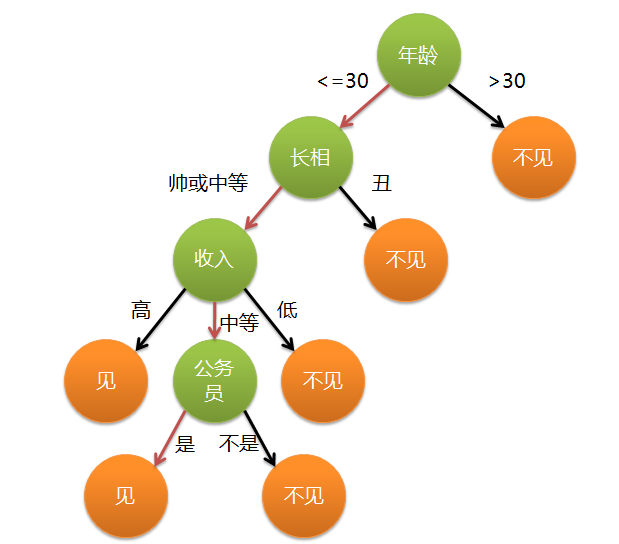

In [41]:
from IPython.display import Image
Image(filename="decidetree.png")

### 练习: 模型调参
细调选择的模型的参数。使用网格搜索（`GridSearchCV`）来至少调整模型的重要参数（至少调整一个），这个参数至少需给出并尝试3个不同的值。你要使用整个训练集来完成这个过程。在接下来的代码单元中，你需要实现以下功能：
- 导入 [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) 和 [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- 创建一个对于这个模型你希望调整参数的字典。
 - 例如: `parameters = {'parameter' : [list of values]}`。
- 初始化你选择的分类器，并将其存储在`clf`中。
- 使用`make_scorer` 创建F<sub>1</sub>评分函数并将其存储在`f1_scorer`中。
 - 需正确设定参数`pos_label`的值！
- 在分类器`clf`上用`f1_scorer` 作为评价函数运行网格搜索,并将结果存储在`grid_obj`中。
- 用训练集(`X_train`, `y_train`)训练grid search object,并将结果存储在`grid_obj`中。

In [55]:
# TODO: 导入 'GridSearchCV' 和 'make_scorer'
from sklearn import grid_search
from sklearn.metrics import make_scorer
# TODO：创建你希望调整的参数列表
# TODO：初始化分类器

parameters = parameters = {'criterion':('gini', 'entropy'), 
                           'splitter':('best', 'random'), 
                           'max_features':('sqrt', 'log2'), 
                           'min_samples_split':range(1,20)}
clf = DecisionTreeClassifier()

# parameters = parameters = {'kernel':('linear', 'rbf', 'poly','sigmoid'), 
#                            'C':range(1,4),
#                            'degree':range(2,5),
#                            'probability':[0,1]}
# clf = svm.SVC()

# parameters = parameters = { 'learning_rate':range(1,6), 
#                            'n_estimators':range(10,60,10)}
# clf = AdaBoostClassifier()

# TODO：用'make_scorer'创建一个f1评分函数
f1_scorer = make_scorer(f1_score, pos_label=0)

# TODO：在分类器上使用f1_scorer作为评分函数运行网格搜索
grid_obj = grid_search.GridSearchCV(clf, parameters, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
# TODO：用训练集训练grid search object来寻找最佳参数
# grid_obj.scorer_ = f1_scorer
grid_obj.fit(X_train, y_train)

# Get the estimator
# 得到预测的结果
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
# 输出经过调参之后的训练集和测试集的F1值
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0001 seconds.
Tuned model has a training F1 score of 0.9372.
Made predictions in 0.0001 seconds.
Tuned model has a testing F1 score of 0.5789.


### 问题 5 - 最终的 F<sub>1</sub> 值
*最终模型的训练和测试的F<sub>1</sub>值是多少？这个值相比于没有调整过参数的模型怎么样？*

 **回答: **训练集的F1是0.9372，测试集的F1是0.5789。<br />
没有调整前，分别是1.0000和0.4706。调整过参数的模型更好。

> **注意**: 当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出**File -> Download as -> HTML (.html)**把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。  